In [1]:
import random
from statistics import mean
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt
import urllib.request as url
import numpy as np
import scanpy as sc
import pandas as pd
import tarfile
import csv
from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin
from wwdk import cluster as cl
from wwdk import data as d
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import umap
from sklearn.datasets import load_digits

In [3]:
class Kmeans(BaseEstimator, ClusterMixin, TransformerMixin):               # Input: processed dataset, Output: clustered data (kmeans, kmeans++)
    def __init__(self, inits=10, k=8, maxit=300, method="++"):
        
        self.labels_ = None
        self.cluster_centers_ = None
        self._inits = inits
        self._k = k
        self._maxit = maxit
        self._method = method
    
    def fit(self,data):
        self._data = data
        best_clust = float('inf')
        
        for i in (range(self._inits)):
            dot = np.random.choice(range(len(self._data)), self._k, replace=False)
            self.cluster_centers_ = self._data[dot]
            for i in range(self._maxit):
                clusters = np.expand_dims(self.cluster_centers_, axis=1)
                data = np.expand_dims(self._data, axis=0)
                eucl = np.linalg.norm(clusters-data, axis=2) # euclidean dist by using integrated numpy function
                self.labels_ = np.argmin(eucl, axis = 0)
                for i in range(self._k): # range of clusters
                    position = np.where(self.labels_ == i) # position im array bestimmen und dann die entspechenden punkte aus data auslesen
                    self.cluster_centers_[i] = self._data[position].mean(axis = 0)
                    #out = pd.DataFrame(data[np.argwhere(dist == i)].squeeze())
                overall_quality = np.sum(np.min(eucl.T, axis=1))
                if overall_quality < best_clust:
                    best_clust = overall_quality
                    best_dist = self.labels_
                    best_centers = self.cluster_centers_
            self.cluster_centers_ = best_centers
            self.labels_ = best_dist
                
        return self

In [2]:
def plot(data, dist, clusters,k):
    for i in range(k):
        graph = pd.DataFrame(data[np.argwhere(dist == i)].squeeze())
        center = pd.DataFrame(clusters[i]).T
        #print("Cluster"+ str(i) +  " -- Assigned Points \n" + str(graph))
        plt.plot(graph[0], graph[1], "o")
        plt.plot(center[0],center[1], "kx")
    plt.show

In [3]:
daten = d.Loader("http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz")
df_pbmc = daten._to_df()

In [4]:
rows = daten._row_names()
columns = np.array(daten._col_names())
df_nonzero_variance = df_pbmc[columns[df_pbmc.var() != 0]]

In [5]:
normalized_pbmc = preprocessing.normalize(df_nonzero_variance)
scaled_pbmc = preprocessing.scale(normalized_pbmc)

In [6]:
pca = PCA()
pca_pbmc = pca.fit_transform(scaled_pbmc)

In [7]:
tsne = TSNE()
pbmc_tsne = tsne.fit_transform(pca_pbmc)

In [8]:
umap1 = umap.UMAP()
pbmc_umap = umap1.fit_transform(pca_pbmc)

In [9]:
pbmc_tsne_clust = cl.Kmeans(method="rng")
pbmc_umap_clust = cl.Kmeans(method="rng")
pbmc_tsne_clust.fit(pbmc_tsne)
pbmc_umap_clust.fit(pbmc_umap)

Kmeans(inits=None, k=None, maxit=None, method=None, tol=None)

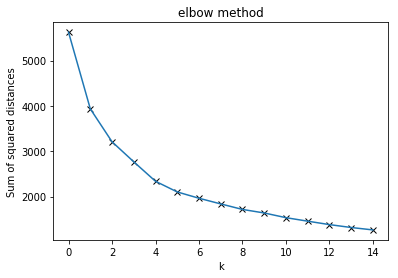

In [44]:
Sum_of_squared_distances = []

for i in range(15):
    km = cl.Kmeans(inits = 10, method = "rng", k = i+1)
    km.fit(pbmc_umap)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(Sum_of_squared_distances, "kx")
plt.plot(Sum_of_squared_distances)
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('elbow method')
plt.show()

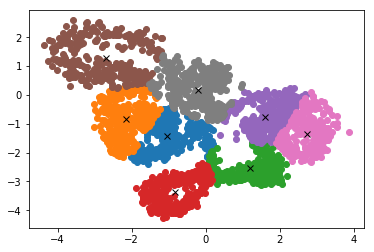

In [46]:
km = cl.Kmeans(inits = 10, method = "rng", k = 8)
km.fit(pbmc_umap)
plot(pbmc_umap,km.labels_, km.cluster_centers_, 8)

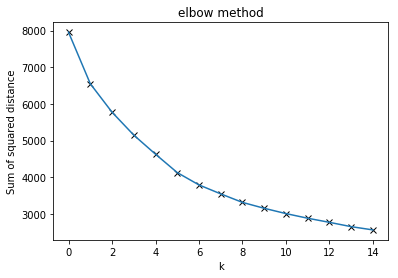

In [39]:
Sum_of_squared_distance = []

for i in range(15):
    kms = cl.Kmeans(inits = 10, method = "rng", k = i+1)
    kms.fit(pbmc_tsne)
    Sum_of_squared_distance.append(kms.inertia_)
    #print(kms.inertia_)
plt.plot(Sum_of_squared_distance, "kx")
plt.plot(Sum_of_squared_distance)
plt.xlabel('k')
plt.ylabel('Sum of squared distance')
plt.title('elbow method')
plt.show()

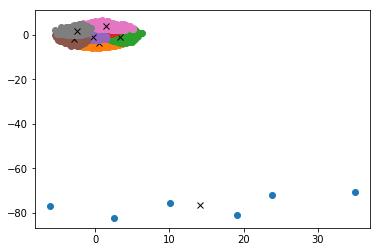

In [42]:
kms = cl.Kmeans(inits = 10, method = "rng", k = 8)
kms.fit(pbmc_tsne)
plot(pbmc_tsne, kms.labels_, kms.cluster_centers_, 8)